# Using Segmentation_Models 

We will use [segmentation_models](https://github.com/qubvel/segmentation_models) package to use several pretrained models to do image segmentation

## Reading Dataset

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import random
import imutils
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
DATA_DIR = '..//data'

In [3]:
seed = 5

In [4]:
# images = os.listdir(os.path.join(DATA_DIR, 'images', 'bird')) + os.listdir(os.path.join(DATA_DIR, 'images', 'insect'))
# masks = os.listdir(os.path.join(DATA_DIR, 'labels', 'bird')) + os.listdir(os.path.join(DATA_DIR, 'labels', 'insect'))
# labels = [1]*len(os.listdir(os.path.join(DATA_DIR, 'labels', 'bird'))) + [2]*len(os.listdir(os.path.join(DATA_DIR, 'labels', 'insect')))

In [5]:
# indices = np.arange(len(images))

In [6]:
# assert len(images) == len(masks)
# assert len(masks) == len(labels)

In [7]:
# widths = []
# heights = []
# for i, image in tqdm_notebook(enumerate(images), total = len(images)):
#     im = cv2.imread('..//data//images//{}//{}'.format('bird' if labels[i]==1 else 'insect', image))
    
#     widths.append(im.shape[0])
#     heights.append(im.shape[1])

In [8]:
# f, ax = plt.subplots(1, 2, figsize = (15, 5))
# ax[0].hist(widths)
# ax[1].hist(heights)
# plt.show()

## Preprocessing Dataset

In [9]:
# def pad_images_to_same_size(images):
#     """
#     :param images: sequence of images
#     :return: list of images padded so that all images have same width and height (max width and height are used)
#     """
#     width_max = 640
#     height_max = 640
    
#     for img in images:
#         h, w = img.shape[0], img.shape[1]
#         width_max = max(width_max, w)
#         height_max = max(height_max, h)

#     images_padded = []
#     for img in images:
#         h, w = img.shape[0], img.shape[1]
#         diff_vert = height_max - h
#         pad_top = diff_vert//2
#         pad_bottom = diff_vert - pad_top
#         diff_hori = width_max - w
#         pad_left = diff_hori//2
#         pad_right = diff_hori - pad_left
#         img_padded = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
#         assert img_padded.shape[:2] == (height_max, width_max)
#         images_padded.append(img_padded)

#     return images_padded

# def readpgm(ID):
        
#         with open(ID) as f:

#             lines = f.readlines()

#         # This ignores commented lines

#         for l in list(lines):

#             if l[0] == '#':

#                 lines.remove(l)

#         # here,it makes sure it is ASCII format (P2)

#         assert lines[0].strip() == 'P2' 

#         # Converts data to a list of integers

#         data = []

#         for line in lines[1:]:

#             data.extend([int(c) for c in line.split()])

#         return np.array(data[3:]).reshape((data[1],data[0]))*255

In [10]:
# for i, idx in tqdm_notebook(enumerate(indices), total = len(indices)):
#     im_path = '..//data//images//{}//'.format('bird' if labels[idx]==1 else 'insect')
#     mask_path = '..//data//labels//{}//'.format('bird' if labels[idx]==1 else 'insect')
#     im = cv2.cvtColor(cv2.imread('{}{}'.format(im_path, images[idx])), cv2.COLOR_BGR2RGB)
#     mask = readpgm('{}{}'.format(mask_path, masks[idx]))
    
#     im_ = pad_images_to_same_size([im])[0]
#     mask_ = pad_images_to_same_size([mask])[0]
    
#     im_path = '..//data//images_//{}//'.format('bird' if labels[idx]==1 else 'insect')
#     mask_path = '..//data//labels_//{}//'.format('bird' if labels[idx]==1 else 'insect')

#     cv2.imwrite('{}//{}'.format(im_path, images[idx]), cv2.cvtColor(im_, cv2.COLOR_RGB2BGR))
#     cv2.imwrite('{}//{}'.format(mask_path, '{}.jpg'.format(masks[idx].split('.')[0])), mask_)

## Building the Data Generator

In [11]:
images = os.listdir(os.path.join(DATA_DIR, 'images_', 'bird')) + os.listdir(os.path.join(DATA_DIR, 'images_', 'insect'))
masks = os.listdir(os.path.join(DATA_DIR, 'labels_', 'bird')) + os.listdir(os.path.join(DATA_DIR, 'labels_', 'insect'))
labels = [1]*len(os.listdir(os.path.join(DATA_DIR, 'labels_', 'bird'))) + [2]*len(os.listdir(os.path.join(DATA_DIR, 'labels_', 'insect')))

In [12]:
assert len(images) == len(masks)
assert len(masks) == len(labels)

In [13]:
indices = np.arange(len(images))

In [14]:
widths = []
heights = []
for i, image in tqdm_notebook(enumerate(images), total = len(images)):
    im = cv2.imread('..//data//images_//{}//{}'.format('bird' if labels[i]==1 else 'insect', image))
    
    widths.append(im.shape[0])
    heights.append(im.shape[1])

E:\Envs\py36tf\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


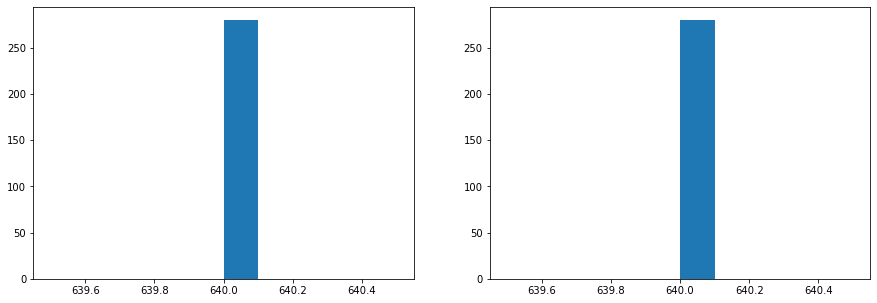

In [15]:
f, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].hist(widths)
ax[1].hist(heights)
plt.show()

In [16]:
# x_train, x_, y_train, y_ = train_test_split(indices, labels, test_size = 0.5, random_state = seed, stratify = labels)
# x_val, x_test, y_val, y_test = train_test_split(x_, y_, test_size = 0.6, random_state = seed, stratify = y_)

In [17]:
# from collections import Counter
# print(Counter(y_train))
# print(Counter(y_val))
# print(Counter(y_test))

In [18]:
# print('Train {}, Val {}, Test {}'.format(len(x_train), len(x_val), len(x_test)))

In [19]:
# for idx, l in tqdm_notebook(zip(x_train, y_train), total = len(x_train)):
#     x = cv2.imread('..//data//images_//{}//{}'.format('bird' if l==1 else 'insect', images[idx]))
#     y = cv2.imread('..//data//labels_//{}//{}'.format('bird' if l==1 else 'insect', masks[idx]))
    
#     cv2.imwrite('..//data//train//{}'.format(images[idx]), x)
#     cv2.imwrite('..//data//trainannot//{}_{}.jpg'.format(masks[idx].split('.')[0], l), y)
    
# for idx, l in tqdm_notebook(zip(x_val, y_val), total = len(x_val)):
#     x = cv2.imread('..//data//images_//{}//{}'.format('bird' if l==1 else 'insect', images[idx]))
#     y = cv2.imread('..//data//labels_//{}//{}'.format('bird' if l==1 else 'insect', masks[idx]))
    
#     cv2.imwrite('..//data//val//{}'.format(images[idx]), x)
#     cv2.imwrite('..//data//valannot//{}_{}.jpg'.format(masks[idx].split('.')[0], l), y)
    
# for idx, l in tqdm_notebook(zip(x_test, y_test), total = len(x_test)):
#     x = cv2.imread('..//data//images_//{}//{}'.format('bird' if l==1 else 'insect', images[idx]))
#     y = cv2.imread('..//data//labels_//{}//{}'.format('bird' if l==1 else 'insect', masks[idx]))
    
#     cv2.imwrite('..//data//test//{}'.format(images[idx]), x)
#     cv2.imwrite('..//data//testannot//{}_{}.jpg'.format(masks[idx].split('.')[0], l), y)

In [20]:
# # helper function for data visualization

# from imgaug import SegmentationMapsOnImage

# def visualize(images, masks, title):
    
#     f, ax = plt.subplots(2, len(images), figsize = (25, 10))
#     for i, (im, ms) in enumerate(zip(images, masks)):
        
#         ax[0][i].imshow(im)
#         ax[1][i].imshow(ms, cmap = 'gray')
#     plt.suptitle(title)
#     plt.show()
        
# sample = random.choices(np.arange(len(x_train)), k = 5)
# imgs = [cv2.cvtColor(cv2.imread('..//data//images_//{}//{}'.format('bird' if y_train[i]==1 else 'insect', images[x_train[i]])), cv2.COLOR_BGR2RGB) for i in sample]
# msks = [cv2.imread('..//data//labels_//{}//{}'.format('bird' if y_train[i]==1 else 'insect', masks[x_train[i]])) for i in sample]
# visualize(imgs, msks, title = 'Training Samples')

# sample = random.choices(np.arange(len(x_val)), k = 5)
# imgs = [cv2.cvtColor(cv2.imread('..//data//images_//{}//{}'.format('bird' if y_val[i]==1 else 'insect', images[x_val[i]])), cv2.COLOR_BGR2RGB) for i in sample]
# msks = [cv2.imread('..//data//labels_//{}//{}'.format('bird' if y_val[i]==1 else 'insect', masks[x_val[i]])) for i in sample]
# visualize(imgs, msks, title = 'Validation Samples')

# sample = random.choices(np.arange(len(x_test)), k = 5)
# imgs = [cv2.cvtColor(cv2.imread('..//data//images_//{}//{}'.format('bird' if y_test[i]==1 else 'insect', images[x_test[i]])), cv2.COLOR_BGR2RGB) for i in sample]
# msks = [cv2.imread('..//data//labels_//{}//{}'.format('bird' if y_test[i]==1 else 'insect', masks[x_test[i]])) for i in sample]
# visualize(imgs, msks, title = 'Test Samples')

In [21]:
# class DataGenerator(keras.utils.Sequence):
#     'Generates data for Keras'
#     def __init__(self, list_IDs, images, masks, labels, label_map = {1: 'bird', 2: 'insect'}, 
#                  train_path = '..//data', mode = 'fit', batch_size=32, 
#                  dim=(640,640), reshape = None, augmentation = None,
#                  n_channels=3, n_classes=3, random_state = 5, shuffle=True):
#         'Initialization'
        
#         self.list_IDs = list_IDs
#         self.images = images
#         self.masks = masks
#         self.labels = labels
#         self.label_map = label_map
#         self.train_path = train_path
#         self.mode = mode
#         self.batch_size = batch_size
#         self.n_channels = n_channels
#         self.dim = dim
#         self.reshape = reshape
#         self.augmentation = augmentation
#         self.n_channels = n_channels
#         self.n_classes = n_classes        
#         self.random_state = random_state
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         # Find list of IDs
#         list_IDs_ = self.list_IDs[index*self.batch_size:(index+1)*self.batch_size]
#         # Generate data
#         if(self.mode == 'fit'):
#             images, maps = self.__data_generation(list_IDs_)
            
#             return images, maps
#         else:
#             images = self.__data_generation(list_IDs_)
            
#             return images
    
#     def __data_generation(self, indices):
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         if(self.reshape is None):
#             image_batch = np.empty((self.batch_size, *self.dim, self.n_channels))
#         else:
#             image_batch = np.empty((self.batch_size, *self.reshape, self.n_channels))
            
#         # Generate data
#         for i, ID in enumerate(indices):
#             # Store sample
#             image_batch[i,] = self.load_image(ID)
        
#         if(self.mode == 'fit'):
# #             if(self.reshape is None):
# #                 mask_batch = np.empty((self.batch_size, *self.dim, self.n_classes))
# #             else:
# #                 mask_batch = np.empty((self.batch_size, *self.reshape, self.n_classes))
#             mask_batch = []

#             # Generate data
#             for i, ID in enumerate(indices):
#                 # Store class
#                 mask_batch.append(self.make_gt(ID))
            
#             if self.augmentation:
#                 for i, ID in enumerate(indices):
#                     sample = self.augmentation(image = image_batch[i,], mask = mask_batch[i])
#                     image_batch[i,], mask_batch[i] = sample['image'], sample['mask']
            
#             return image_batch, mask_batch
#         else:
#             return image_batch
        
#     def load_image(self, ID):
        
#         path = '{}//images_//{}//{}'.format(self.train_path, self.label_map[self.labels[ID]], self.images[ID])
#         img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
#         img = img.astype(np.float32) / 255.
        
#         if(self.reshape is not None):
#             img = imutils.resize(img, height = self.reshape[0])

#         return img
    
#     def make_gt(self, ID):
        
#         mask = cv2.imread('{}//labels_//{}//{}.jpg'.format(self.train_path, 
#                                                            self.label_map[self.labels[ID]], self.masks[ID].split('.')[0]))
#         mask = mask.astype(np.float32)/255.
#         mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
                
#         gt = np.zeros((*self.dim, self.n_classes))
        
#         if self.labels[ID]  == 1:
#             gt[:, :, 1] = mask
#             gt[:, :, 0] = 1 - gt[:, :, 1]
#         elif self.labels[ID] == 2:
#             gt[:, :, 2] = mask
#             gt[:, :, 0] = 1 - gt[:, :, 2]
            
#         if(self.reshape is not None):
#             gt = imutils.resize(gt, height = self.reshape[0])
            
#         return gt

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.seed(self.random_state)
#             np.random.shuffle(self.indexes)


In [22]:
# trainGen = DataGenerator(x_train, images, masks, labels, batch_size=5, reshape = (320, 320), 
#                          augmentation = get_training_augmentation())

In [23]:
# visualize(trainGen[0][0], trainGen[0][1], title = 'Training Samples')

In [24]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if(len(image.shape) == 2):
            plt.imshow(image, cmap = 'gray')
        else:
            plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            reshape = None,
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.mask_ids = os.listdir(masks_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.mask_ids]
        self.reshape = reshape
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gt = cv2.imread(self.masks_fps[i])
        gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
        gt = gt/255.0
        
        # extract certain classes from mask (e.g. cars)
        label = int(self.mask_ids[i].split('.')[0][-1])
        mask = np.zeros((gt.shape[0], gt.shape[1], 3))
        
        if(label == 1):
            mask[:, :, 1] = gt
        else:
            mask[:, :, 2] = gt
        
        mask[:, :, 0] = 1 - gt
        
        if self.reshape:
            image = imutils.resize(image, height = self.reshape[0])
            mask = imutils.resize(mask, height = self.reshape[0])
            
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   
            
import albumentations as A

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

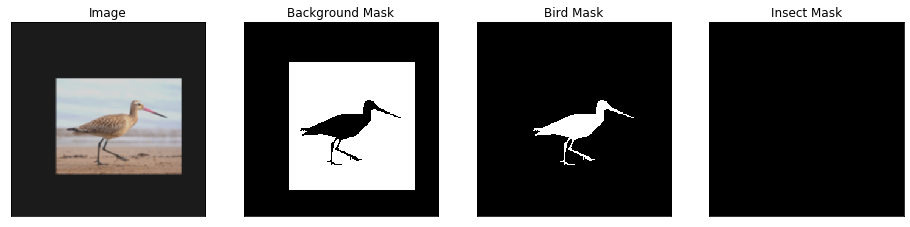

In [25]:
# Lets look at augmented data we have
dataset = Dataset('..//data//train', '..//data//trainannot', classes=['bird', 'insect'], 
                  reshape = (240, 240), augmentation=get_training_augmentation())

image, mask = dataset[2] # get some sample
visualize(
    image=image, 
    background_mask=mask[..., 0].squeeze(),
    bird_mask=mask[..., 1].squeeze(),
    insect_mask=mask[..., 2].squeeze(),    
)

## Building Segmentation Model

In [26]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [27]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 1
CLASSES = ['bird', 'insect']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [28]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [29]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [30]:
# Dataset for train images
train_dataset = Dataset(
    '..//Data//train', 
    '..//Data//trainannot',
    reshape = (240, 240),
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    '..//Data//val',
    '..//Data//valannot',
    reshape = (240, 240),
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model_aug.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7)
]

In [31]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
    verbose = 1
)

Epoch 1/40
140/140 [==============================] - 158s 1s/step - loss: 0.7545 - iou_score: 0.2203 - f1-score: 0.2830 - val_loss: 0.7637 - val_iou_score: 0.3605 - val_f1-score: 0.4069
Epoch 2/40
140/140 [==============================] - 76s 544ms/step - loss: 0.6204 - iou_score: 0.3289 - f1-score: 0.3866 - val_loss: 0.7522 - val_iou_score: 0.3971 - val_f1-score: 0.4375
Epoch 3/40
140/140 [==============================] - 76s 541ms/step - loss: 0.5428 - iou_score: 0.3454 - f1-score: 0.4038 - val_loss: 0.7554 - val_iou_score: 0.3479 - val_f1-score: 0.4103
Epoch 4/40
140/140 [==============================] - 74s 525ms/step - loss: 0.5037 - iou_score: 0.3584 - f1-score: 0.4130 - val_loss: 0.7777 - val_iou_score: 0.3479 - val_f1-score: 0.4115
Epoch 5/40
140/140 [==============================] - 74s 526ms/step - loss: 0.4867 - iou_score: 0.3691 - f1-score: 0.4209 - val_loss: 0.6853 - val_iou_score: 0.3836 - val_f1-score: 0.4342
Epoch 6/40
140/140 [==============================] - 74s

In [32]:
# train model
history_2 = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=50, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
    verbose = 1
)

Epoch 1/50
140/140 [==============================] - 63s 451ms/step - loss: 0.3757 - iou_score: 0.4523 - f1-score: 0.4919 - val_loss: 0.6503 - val_iou_score: 0.3635 - val_f1-score: 0.4423
Epoch 2/50
140/140 [==============================] - 63s 449ms/step - loss: 0.3768 - iou_score: 0.4513 - f1-score: 0.4893 - val_loss: 0.5706 - val_iou_score: 0.4057 - val_f1-score: 0.4707
Epoch 3/50
140/140 [==============================] - 63s 453ms/step - loss: 0.3667 - iou_score: 0.4599 - f1-score: 0.4943 - val_loss: 0.5427 - val_iou_score: 0.4238 - val_f1-score: 0.4878
Epoch 4/50
140/140 [==============================] - 67s 476ms/step - loss: 0.3751 - iou_score: 0.4532 - f1-score: 0.4908 - val_loss: 0.6073 - val_iou_score: 0.3786 - val_f1-score: 0.4533
Epoch 5/50
140/140 [==============================] - 72s 511ms/step - loss: 0.3723 - iou_score: 0.4546 - f1-score: 0.4924 - val_loss: 0.6177 - val_iou_score: 0.3803 - val_f1-score: 0.4595
Epoch 6/50
140/140 [==============================] - 7

In [33]:
# train model
history_3 = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=50, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
    verbose = 1
)

Epoch 1/50
140/140 [==============================] - 63s 448ms/step - loss: 0.3623 - iou_score: 0.4758 - f1-score: 0.5125 - val_loss: 0.5908 - val_iou_score: 0.3825 - val_f1-score: 0.4578
Epoch 2/50
140/140 [==============================] - 64s 459ms/step - loss: 0.3505 - iou_score: 0.4994 - f1-score: 0.5346 - val_loss: 0.5993 - val_iou_score: 0.3748 - val_f1-score: 0.4511
Epoch 3/50
140/140 [==============================] - 65s 461ms/step - loss: 0.3539 - iou_score: 0.4884 - f1-score: 0.5230 - val_loss: 0.5553 - val_iou_score: 0.3816 - val_f1-score: 0.4545
Epoch 4/50
140/140 [==============================] - 64s 456ms/step - loss: 0.3542 - iou_score: 0.4892 - f1-score: 0.5248 - val_loss: 0.5935 - val_iou_score: 0.3732 - val_f1-score: 0.4503
Epoch 5/50
140/140 [==============================] - 63s 451ms/step - loss: 0.3510 - iou_score: 0.5038 - f1-score: 0.5407 - val_loss: 0.5744 - val_iou_score: 0.3931 - val_f1-score: 0.4692
Epoch 6/50
140/140 [==============================] - 6

In [ ]:
# train model
history_3 = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=100, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
    verbose = 1
)

Epoch 1/100
140/140 [==============================] - 63s 449ms/step - loss: 0.3514 - iou_score: 0.5105 - f1-score: 0.5438 - val_loss: 0.5809 - val_iou_score: 0.4031 - val_f1-score: 0.4763
Epoch 2/100
140/140 [==============================] - 63s 450ms/step - loss: 0.3445 - iou_score: 0.5421 - f1-score: 0.5760 - val_loss: 0.5910 - val_iou_score: 0.4073 - val_f1-score: 0.4829
Epoch 3/100
140/140 [==============================] - 63s 451ms/step - loss: 0.3422 - iou_score: 0.5466 - f1-score: 0.5786 - val_loss: 0.6278 - val_iou_score: 0.3808 - val_f1-score: 0.4601
Epoch 4/100
140/140 [==============================] - 63s 449ms/step - loss: 0.3489 - iou_score: 0.5246 - f1-score: 0.5611 - val_loss: 0.5928 - val_iou_score: 0.3845 - val_f1-score: 0.4635
Epoch 5/100
140/140 [==============================] - 64s 455ms/step - loss: 0.3449 - iou_score: 0.4978 - f1-score: 0.5309 - val_loss: 0.6942 - val_iou_score: 0.3775 - val_f1-score: 0.4369
Epoch 6/100
140/140 [=============================

In [ ]:
plt.plot(history.history['val_iou_score'], label = 'val_iou')
plt.plot(history.history['iou_score'], label = 'train_iou')
plt.legend()
plt.show()

In [ ]:
testGen = DataGenerator(x_test, images, masks, labels, batch_size=5, reshape = (320, 320))

In [ ]:
pred = model.predict_generator(testGen)

In [ ]:
visualize(testGen[3][0][0:5], pred[15:20], title = 'Prediction')

In [ ]:
plt.imshow(pred[0][:, :, 0], cmap = 'gray')

In [ ]:
plt.imshow(pred[0][:, :, 1], cmap = 'gray')

In [ ]:
plt.imshow(pred[0][:, :, 2], cmap = 'gray')